# HW3: Fisher Model

## What is our goal?   

Our goal is to solve the Fisher model as examples of a scalar (single component) reaction-diffusion equations numerically. We intend to go through the following steps: 


### To do: Fisher Equation 
1. can time-integration be done more eff
2. provide better post-processing, using, e.g., heatmap()

## Import Libraries

In [11]:
import numpy as np
print("Succesfully imported %s -- Version: %s"%(np.__name__,np.__version__))
import scipy
print("Succesfully imported %s -- Version: %s"%(scipy.__name__,scipy.__version__))
import matplotlib.pyplot as plt
print("Succesfully imported %s"%plt.__name__)
import pandas as pd
print("Succesfully imported %s -- Version: %s"%(pd.__name__,pd.__version__))
import sympy as sym 
print("Succesfully imported %s -- Version: %s"%(sym.__name__,sym.__version__))
from scipy import optimize
print("Succesfully imported %s"%optimize.__name__)
from scipy.optimize import fsolve
print("Succesfully imported %s"%fsolve.__name__)
from scipy.signal import find_peaks
print("Succesfully imported %s"%find_peaks.__name__)
from scipy.linalg import orth
print("Succesfully imported %s"%orth.__name__)
from scipy.integrate import odeint
print("Succesfully imported %s"%odeint.__name__)
from scipy.integrate import solve_ivp

Succesfully imported numpy -- Version: 1.20.1
Succesfully imported scipy -- Version: 1.6.2
Succesfully imported matplotlib.pyplot
Succesfully imported pandas -- Version: 1.2.4
Succesfully imported sympy -- Version: 1.8
Succesfully imported scipy.optimize
Succesfully imported fsolve
Succesfully imported find_peaks
Succesfully imported orth
Succesfully imported odeint


## Section 1/: Introduction and Model Description

Extend version of introduction given above.   

## Section 2/: Fisher model as ODE 

Work out the two examples on wiki using implicit time integration. Perform spectral analysis of the Jacobian. See wiki page for example of spectral analysis. Give physical interpretation. 

### Section 1.2/: Analytical Solution 

\begin{equation}
u'(t) = \frac{d \, u(t)}{dt} 
      = u^2 - u = u \, (u - 1)\text{ supplied with initial condition } u(t=0) = u_0 \, . 
\end{equation}

The analytical solution method critically relies on the fact that the ordinary differential equation is <b> seperable</b>. The ordinary differential equation equivalently written as 
\begin{equation}
  \underbrace{ \frac{ du }{ u^2 - u} }_{only\,function\,of\,u} 
  = \underbrace{ dt }_{only\,function\,of\,t} \, .  
\end{equation}
After performing integration of the left and right-hand side, this equation becomes 
\begin{equation}
  \int^{u} \frac{ du }{ u^2 - u} = \int^t dt = t + C \, ,   
\end{equation}
where $C$ is an integration constant. 

To compute the integral on the left-hand side, we split the fraction $1/(u^2 - u)$ into partial fractions as follows 
\begin{equation}
  \frac{ 1 }{ u^2 - u} = \frac{ 1 }{ u \, (u - 1)} 
  = \frac{ 1 }{ u - 1} - \frac{ 1 }{ u } \, .      
\end{equation}
 
The above splitting allows to compute the integral $\int^{u} \frac{ du }{ u^2(t) - u(t)}$ as 
\begin{eqnarray}
  \int^{u} \frac{ du }{ u^2(t) - u(t)} 
    & = & \int^{u}  \frac{ du }{ u -1 } + \int^{u}  \frac{ - du }{ u } \, .      
\end{eqnarray}
The assumption that $0 < u(t) < 1$ allows to simplify $|u|$ and $|1-u|$ as $u$ and $1-u$, respectively, and to obtain 
\begin{eqnarray}
  \int^{u} \frac{ du }{ u^2(t) - u(t)} = \log(u-1) - \log(u) = \log( \frac{ u- 1}{u}) \, .      
\end{eqnarray}

The analytical solution is thus given by 
\begin{equation}
   \fbox{$ u(t) = \frac{1}{ 1 - C \exp(t)} $}
\end{equation}
where $C$ is an integration constant that can be determined using the initial conditions. 

### Plot of the analytical solution

Here we plot the analytical solution obtained. 

### Section 2.2/: Numerical Solution 

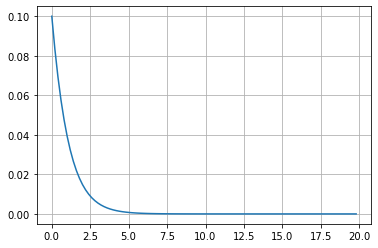

In [12]:
def fisher_ode_rhs(t, u): return u**2-u
# 
Tstart = 0
u0 = 1e-1; Tend = 20  
tsamples = np.arange(Tstart,Tend,Tend/100)
# 
sol_radau = solve_ivp(fisher_ode_rhs, [Tstart, Tend], [u0], method="Radau", t_eval=tsamples)
# 
fig = plt.figure()
plt.plot(sol_radau.t,sol_radau.y[0])
plt.grid()

## Section 3:/ Fisher Equation in x and t
We reproduce the reference solution for Fisher equation [Fisher Equation](https://people.maths.ox.ac.uk/trefethen/pdectb/fisher2.pdf)

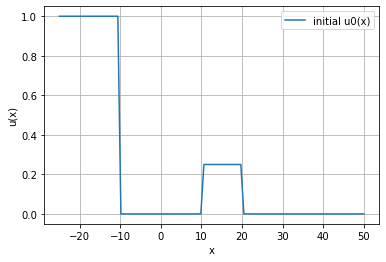

In [13]:
#..set the initial solution 
nsamples = 100 
xvec = np.linspace(-25,50,nsamples)
u0 = (xvec<=-10)+0.25*((10<=xvec)*(xvec<=20))

#..plot the computed solution 
plt.plot(xvec,u0,label='initial u0(x)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend(loc='best')
plt.grid()
plt.show()

(101, 41)


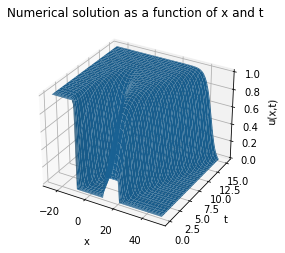

In [14]:
def poisson_1d(N):
    h = 75/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=0; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=0; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    dudt = -np.dot(A,u) + u*(1-u)
    return dudt

N = 100

A = poisson_1d(N)

#..set initial guess   
xvec = np.linspace(-25,50,N+1)
u0 = (xvec<=-10)+0.25*((10<=xvec)*(xvec<=20))

#..perform time integration  
computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,),t_span=[0,15],y0=u0)

#..prepare variables for plotting 
t = computed.t
XX, TT = np.meshgrid(xvec,t[1:])

#..post-processing 
fig = plt.figure()
axes = fig.gca(projection='3d')
z = computed.y[:,1:]
print(np.shape(z))
axes.plot_surface(XX,TT,z.T)
axes.set_xlabel('x')
axes.set_ylabel('t')
axes.set_zlabel('u(x,t)')
axes.set_title('Numerical solution as a function of x and t')
#plt.imshow(z)
plt.show()

## References 

To be extended. 

1. [Reaction-Diffusion Systems and Gray-Scott Model](https://en.wikipedia.org/wiki/Reaction–diffusion_system)

2. [Fisher and KPP Equation](https://en.wikipedia.org/wiki/Fisher%27s_equation). Document analytical solutions for the Fisher equation. Source term $F(u) = u(1-u)$. Very similar to growth model in ANM-2021. Explain solutions. Solve Fisher equation using finite differences in space and implicit time-stepping with variable time step;